In [253]:
from torchvision import transforms, utils
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import torch
import os

from myutils import *
from mymodels import*

In [277]:
class CustomDataSet(Dataset):
    def __init__(self, csv_path, root_dir, transform=None):
        """
        Params:
            csv_path (str): path to the csv file containing images paths and labels
            root_dir (str): path to the folder containing the images
            transform (callable, optional): optional transformation to the data
        """
        data = pd.read_csv(csv_path)
        
        self.img_path = np.array(data['Paths'],str)
        self.label = np.array(data['Label'],int)
        
        self.root_dir = root_dir
        self.transform = transform
        

    def __len__(self):
        return len(self.img_path)
                         
    
    def __getitem__(self, idx):
        """
        This methods loads the next sample form the dataset using the name of the image from the
        dataset. The image is loaded as PIL image and then converted into RGB as there are different
        types of formats in the images, this allows us to treat them all equally.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Creates path to the images from working directory, in this case 
        img_name = os.path.join(self.root_dir, self.img_path[idx])
        img = Image.open(img_name)
        img = img.convert('RGB') # Converts to RGB values the image
    
        label = self.label[idx]
        
        sample = {'image': img, 'label': label}
        
        if self.transform:
            sample['image'] = self.transform(sample['image'])
            
        return sample

In [278]:
IMG_SIZE = (64,64)
BATCH_SIZE = 128
classes = {0: 'Closed', 1: 'Open'}

csv_file = os.path.join(os.path.join(os.getcwd(),'Mouth_DataSet'),'Mouth_frame.csv')
root_path = os.path.join(os.getcwd(),'Mouth_DataSet')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using: ', device)
print('Classification classes: ', classes)

Using:  cpu
Classification classes:  {0: 'Closed', 1: 'Open'}


In [279]:
transform = transforms.Compose([transforms.Resize(IMG_SIZE, interpolation=Image.NEAREST),
                               transforms.ToTensor()])
dataset = CustomDataSet(csv_path=csv_file, root_dir=root_path, transform=transform)

In [280]:
split = int(len(dataset)*0.8)
train_set, val_set = torch.utils.data.random_split(dataset,
                                                   [split, len(dataset)-split],
                                                   generator=torch.Generator().manual_seed(42))
print('Train samples: ', len(train_set))
print('Validation samples: ', len(val_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE)

Train samples:  4095
Validation samples:  1024


In [281]:
single_batch = next(iter(train_loader))

images = single_batch["image"]
label = single_batch["label"]

print(images.shape)
print(label.shape)

torch.Size([128, 3, 64, 64])
torch.Size([128])


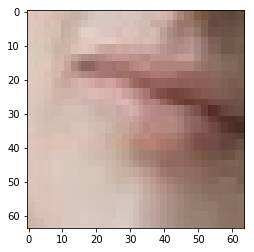

In [282]:
single_img = single_batch["image"][0]
plt.imshow(single_img.permute(1,2,0))

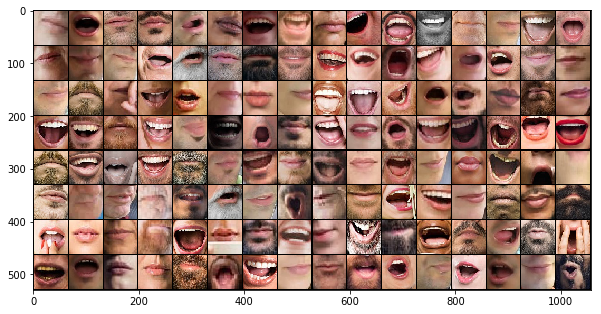

In [283]:
single_batch_grid = utils.make_grid(single_batch['image'], nrow=16)

plt.figure(figsize = (10,10))
plt.imshow(single_batch_grid.permute(1,2,0))

In [285]:
params_model = get_network_params(cnn=True)

model = Network(params_model)
model = model.to(device)

print(params_model)
print(model)

{'shape': (3, 64, 64), 'initial_filters': 8, 'num_fc1': 100, 'dropout_rate': 0.25, 'num_classes': 1}
Network(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten()
  (fc1): Linear(in_features=256, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [286]:
L_RATE = 0.0001
criterion = nn.BCELoss()
optimiser = torch.optim.Adam(model.parameters(), lr = L_RATE)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=20, verbose=1)

In [287]:
params_train = get_train_params(train_loader,val_loader,20,optimiser,lr_scheduler,criterion,'weights_mouth.pt',True)
print(params_train)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x000001EF114D1E80>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x000001EF11408940>, 'epochs': 20, 'optimiser': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
), 'lr_change': <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x000001EF11B06CF8>, 'loss_fn': BCELoss(), 'weight_path': 'weights_mouth.pt', 'check': True}


In [288]:
# Train and validate model with Sanity Check
model, loss_hist, metric_hist = fit(model, params_train)

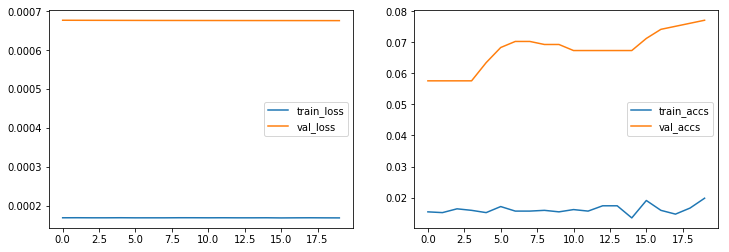

In [289]:
epochs = params_train['epochs']

fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(loss_hist['train'], label='train_loss')
plt.plot(loss_hist['val'], label='val_loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(metric_hist['train'], label='train_accs')
plt.plot(metric_hist['val'], label='val_accs')
plt.legend()
plt.show()

In [290]:
# Train and validate model after Sanity Check
params_train = get_train_params(train_loader,val_loader,50,optimiser,lr_scheduler,criterion,'weights_mouth.pt',False)
model, loss_hist, metric_hist = fit(model, params_train)

C:\Users\usuario\.conda\envs\py3_6\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([127])) that is different to the input size (torch.Size([127, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch    40: reducing learning rate of group 0 to 5.0000e-05.
Epoch    61: reducing learning rate of group 0 to 2.5000e-05.


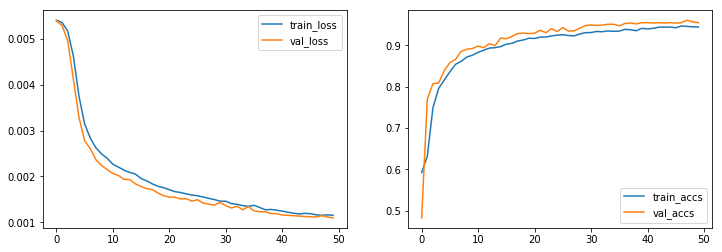

In [291]:
epochs = params_train['epochs']

fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(loss_hist['train'], label='train_loss')
plt.plot(loss_hist['val'], label='val_loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(metric_hist['train'], label='train_accs')
plt.plot(metric_hist['val'], label='val_accs')
plt.legend()
plt.show()